### Poisson Ratings
https://penaltyblog.readthedocs.io/en/latest/ratings/massey_ratings.html

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import penaltyblog as pb

In [5]:
DATA_DIR = os.path.join(os.getcwd(), 'data/')
CHART_DIR = os.path.join(os.getcwd(), 'charts/')

In [6]:
#data_file = './data/FMF_TA_2021.csv'
data_file = './data/FMF_TA_2022.csv'
df = pd.read_csv(data_file, index_col=0)
df.head()

,AMÉ,ATL,ASL,CAZ,GUA,JUÁ,LEÓ,MAZ,MON,NEC,PAC,PUE,QUE,SAN,TIJ,TOL,UNL,UNM
Home \ Away,,,,,,,,,,,,,,,,,,
América,-,0-0,3-0,7-0,2-1,2-1,-,-,-,-,-,-,-,3-3,-,1-0,2-1,-
Atlas,-,-,1-3,3-2,-,0-1,-,-,-,1-0,-,1-1,3-1,-,1-2,1-0,-,0-0
Atlético San Luis,-,-,-,0-0,-,-,1-2,-,0-1,1-2,1-2,-,-,-,0-0,-,0-3,3-2
Cruz Azul,-,-,-,-,2-1,-,2-1,2-0,-,1-0,1-2,2-2,2-1,-,1-2,2-3,-,-
Guadalajara,-,1-1,0-1,-,-,0-0,0-0,-,1-0,-,0-0,1-0,-,-,-,-,1-4,3-1


In [7]:
df.index = df.columns
rows = []
for i in df.index:
    for c in df.columns:
        if i == c: continue
        #print(i,c)
        score = df.loc[i, c]
        #print(score)
        if score == '-': continue
        ssplit = score.split('-')
        #print(ssplit[0],ssplit[1])
        rows.append([i, c, int(ssplit[0]), int(ssplit[1])])
        #rows.append([i, c, ssplit[0], ssplit[1]])
df = pd.DataFrame(rows, columns = ['HomeTeam', 'AwayTeam','FTHG',
                                   'FTAG'])
df.head()

,HomeTeam,AwayTeam,FTHG,FTAG
0,AMÉ,ATL,0,0
1,AMÉ,ASL,3,0
2,AMÉ,CAZ,7,0
3,AMÉ,GUA,2,1
4,AMÉ,JUÁ,2,1


In [8]:
df.home_score = df['FTHG'].astype('int')
df.away_score = df['FTAG'].astype('int')

In [9]:
df.dtypes

HomeTeam    object
AwayTeam    object
FTHG         int64
FTAG         int64
dtype: object

In [10]:
df[["FTHG", "FTAG"]].mean()

FTHG    1.522876
FTAG    1.222222
dtype: float64

Text(0.5, 1.0, 'Number of Goals Scored Per Match')

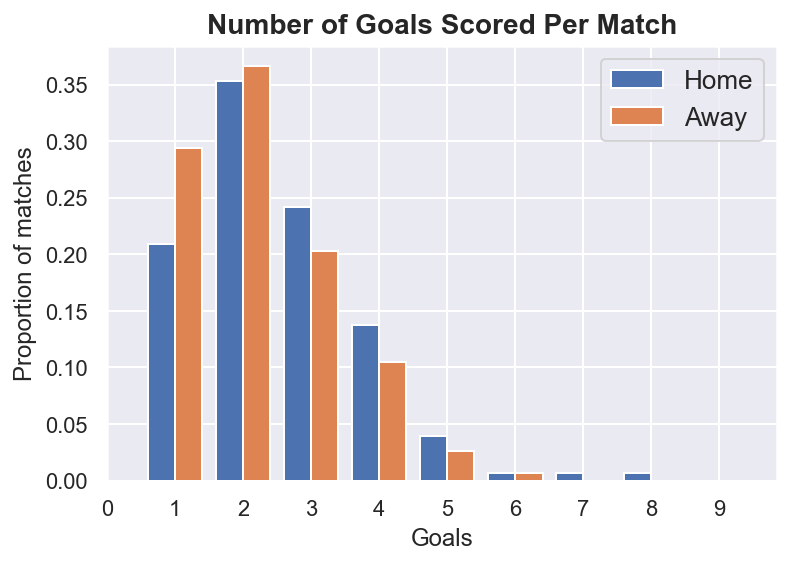

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

max_goals = 10
plt.hist(
    df[["FTHG", "FTAG"]].values, range(max_goals), 
                 label=["Home", "Away"], density=True
)
plt.xticks([i - 0.5 for i in range(max_goals)], 
            [i for i in range(max_goals)])
plt.xlabel("Goals")
plt.ylabel("Proportion of matches")
plt.legend(loc="upper right", fontsize=13)
plt.title("Number of Goals Scored Per Match", size=14, 
          fontweight="bold")

Text(0.5, 1.0, 'Number of Goals Scored Per Match')

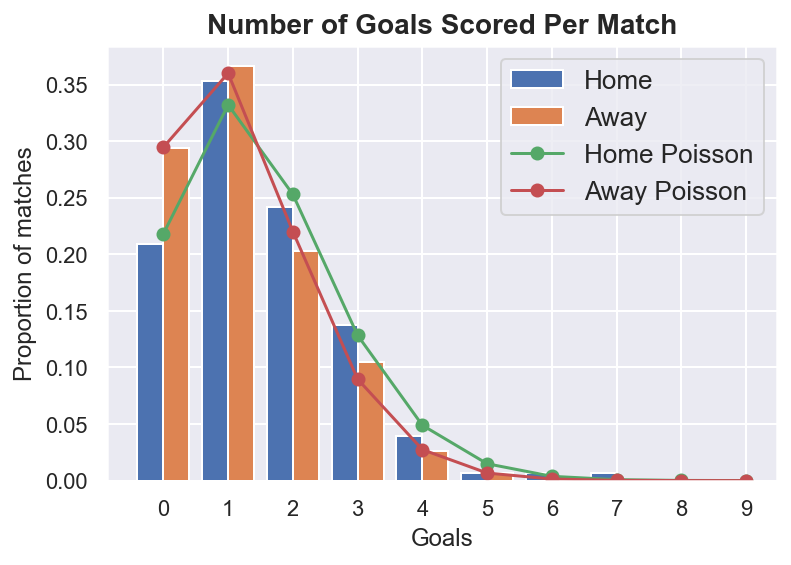

In [12]:
import numpy as np
from scipy.stats import poisson

home_poisson = poisson.pmf(range(10), df["FTHG"].mean())
away_poisson = poisson.pmf(range(10), df["FTAG"].mean())

max_goals = 10
plt.hist(
    df[["FTHG", "FTAG"]].values, range(max_goals), 
               label=["Home", "Away"], density=True
)

plt.plot(
    [i - 0.5 for i in range(1, max_goals + 1)],
    home_poisson,
    linestyle="-",
    marker="o",
    label="Home Poisson",
)

plt.plot(
    [i - 0.5 for i in range(1, max_goals + 1)],
    away_poisson,
    linestyle="-",
    marker="o",
    label="Away Poisson",
)


plt.xticks([i - 0.5 for i in range(1, max_goals + 1)], 
           [i for i in range(max_goals)])
plt.xlabel("Goals")
plt.ylabel("Proportion of matches")
plt.legend(loc="upper right", fontsize=13)
plt.title("Number of Goals Scored Per Match", size=14, fontweight="bold")

In [13]:
def log_likelihood(
    goals_home_observed,
    goals_away_observed,
    home_attack,
    home_defence,
    away_attack,
    away_defence,
    home_advantage,
):
    goal_expectation_home = np.exp(home_attack + 
                                   away_defence + home_advantage)
    goal_expectation_away = np.exp(away_attack + home_defence)

    if goal_expectation_home < 0 or goal_expectation_away < 0:
        return 10000    

    home_llk = poisson.pmf(goals_home_observed, goal_expectation_home)
    away_llk = poisson.pmf(goals_away_observed, goal_expectation_away)

    log_llk = np.log(home_llk) + np.log(away_llk)

    return -log_llk

In [14]:
from scipy.optimize import minimize


def fit_poisson_model():
    teams = np.sort(np.unique(np.concatenate([df["HomeTeam"], 
                                              df["AwayTeam"]])))
    n_teams = len(teams)

    params = np.concatenate(
        (
            np.random.uniform(0.5, 1.5, (n_teams)),  # attack strength
            np.random.uniform(0, -1, (n_teams)),  # defence strength
            [0.25],  # home advantage
        )
    )

    def _fit(params, df, teams):
        attack_params = dict(zip(teams, params[:n_teams]))
        defence_params = dict(zip(teams, params[n_teams : 
                                                (2 * n_teams)]))
        home_advantage = params[-1]

        llk = list()
        for idx, row in df.iterrows():
            tmp = log_likelihood(
                row["FTHG"],
                row["FTAG"],
                attack_params[row["HomeTeam"]],
                defence_params[row["HomeTeam"]],
                attack_params[row["AwayTeam"]],
                defence_params[row["AwayTeam"]],
                home_advantage,
            )
            llk.append(tmp)

        return np.sum(llk)

    options = {
        "maxiter": 100,
        "disp": False,
    }

    constraints = [{"type": "eq", "fun": lambda x: 
                    sum(x[:n_teams]) - n_teams}]

    res = minimize(
        _fit,
        params,
        args=(df, teams),
        constraints=constraints,
        options=options,
    )

    model_params = dict(
        zip(
            ["attack_" + team for team in teams]
            + ["defence_" + team for team in teams]
            + ["home_adv"],
            res["x"],
        )
    )

    return model_params

model_params = fit_poisson_model()

In [15]:
from pprint import pprint

pprint(model_params)

{'attack_AMÉ': 1.5294918241593352,
 'attack_ASL': 0.5932424455688271,
 'attack_ATL': 0.6530839071816966,
 'attack_CAZ': 1.1644094460952015,
 'attack_GUA': 0.8266968415633936,
 'attack_JUÁ': 0.6484643060785147,
 'attack_LEÓ': 1.1321085295659892,
 'attack_MAZ': 0.7187321234427395,
 'attack_MON': 1.2482048693030112,
 'attack_NEC': 0.8675656480264295,
 'attack_PAC': 1.2227351067161583,
 'attack_PUE': 1.0889989929523922,
 'attack_QUE': 0.824716791763803,
 'attack_SAN': 1.5214832893906738,
 'attack_TIJ': 0.7928100028541921,
 'attack_TOL': 1.1820122623922444,
 'attack_UNL': 1.0380965939827813,
 'attack_UNM': 0.947147018962617,
 'defence_AMÉ': -1.1249313946283128,
 'defence_ASL': -0.8050465962562036,
 'defence_ATL': -0.7918144230587428,
 'defence_CAZ': -0.4549899275428127,
 'defence_GUA': -1.1690525357588843,
 'defence_JUÁ': -1.0648001263801727,
 'defence_LEÓ': -0.6802037574173362,
 'defence_MAZ': -0.8290947886144787,
 'defence_MON': -1.4091617387072273,
 'defence_NEC': -0.7414885979660509,
 '

In [16]:
def predict(home_team, away_team, params, max_goals=10):
    home_attack = params["attack_" + home_team]
    home_defence = params["defence_" + home_team]
    away_attack = params["attack_" + away_team]
    away_defence = params["defence_" + away_team]
    home_advantage = params["home_adv"]

    home_goal_expectation = np.exp(home_attack + away_defence 
                                   + home_advantage)
    away_goal_expectation = np.exp(away_attack + home_defence)

    home_probs = poisson.pmf(list(range(max_goals + 1)), 
                             home_goal_expectation)
    away_probs = poisson.pmf(range(max_goals + 1), 
                             away_goal_expectation)

    probability_matrix = np.outer(home_probs, away_probs)

    return probability_matrix

In [29]:
EL = 'PAC'
EV = 'MON'

In [30]:
probs = predict(EL, EV, model_params, 4)
pprint(probs)

array([[0.13554894, 0.13030036, 0.06262751, 0.0200675 , 0.00482262],
       [0.14058369, 0.13514016, 0.06495371, 0.02081288, 0.00500175],
       [0.07290273, 0.07007987, 0.03368316, 0.01079297, 0.00259376],
       [0.02520353, 0.02422762, 0.01164475, 0.00373129, 0.0008967 ],
       [0.00653492, 0.00628188, 0.00301932, 0.00096747, 0.0002325 ]])


In [31]:
# draw

E = np.sum(np.diag(probs))
print(f'Probabilidad que empaten {EL} vs {EV} es = {E}')

Probabilidad que empaten PAC vs MON es = 0.30833604951533217


In [32]:
# home win

L = np.sum(np.tril(probs, -1))
print(f'Probabilidad que gane {EL} vs {EV} es = {L}')

Probabilidad que gane PAC vs MON es = 0.36144577803880673


In [33]:
# away win
V = np.sum(np.triu(probs, 1))
print(f'Probabilidad que pierda {EL} vs {EV} es = {V}')


Probabilidad que pierda PAC vs MON es = 0.32286976572645965


In [34]:
print(f'{EL} vs {EV} L {100/L} E {100/E} V {100/V}')

PAC vs MON L 276.666670565629 E 324.3214672990336 V 309.7224039389355


In [35]:
probs = predict(EV, EL, model_params, 4)
pprint(probs)

array([[0.13117514, 0.1088648 , 0.04517451, 0.01249707, 0.00259289],
       [0.15758102, 0.13077955, 0.05426825, 0.01501276, 0.00311484],
       [0.09465123, 0.0785529 , 0.03259629, 0.00901743, 0.00187094],
       [0.03790159, 0.03145526, 0.01305267, 0.00361089, 0.00074919],
       [0.01138282, 0.00944682, 0.00392005, 0.00108444, 0.000225  ]])


In [36]:
# draw
print(f'Probabilidad que empaten {EV} vs {EL} es =')
np.sum(np.diag(probs))

Probabilidad que empaten MON vs PAC es =


0.29838686514803614

In [37]:
# home win
print(f'Probabilidad que gane {EV} vs {EL} es =')
np.sum(np.tril(probs, -1))

Probabilidad que gane MON vs PAC es =


0.43902879754434904

In [38]:
# away win
print(f'Probabilidad que pierda {EV} vs {EL} es =')
np.sum(np.triu(probs, 1))

Probabilidad que pierda MON vs PAC es =


0.253162663960941

In [39]:
100/13.77

7.262164124909223